In [1]:
%load_ext autoreload
%autoreload 2

In [38]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams
from glasbey import create_palette

palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

s_palette = sns.cubehelix_palette(as_cmap=True)
pal = sns.color_palette("dark")
cpal = sns.cubehelix_palette(start=-0.25, rot=2, as_cmap=True)
g_palette = create_palette(1024)

In [89]:
from src.utils.tracklets import import_tracklets

roots = ["embryo007", "embryo008", "embryo014a", "embryo016", "embryo018"]
datapath = Path().cwd().parent / "data" / "interim" / "confocal"
plotpath = datapath / "plots"
plotpath.mkdir(exist_ok=True)

spots, tracklets, metadatas, tracklets_joined = import_tracklets(datapath, roots)


In [51]:
# plot cpal cbar
fig, ax = plt.subplots(figsize=(1, 6))
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cpal, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax)
plt.savefig(plotpath / "cousins/cpal_cbar.png", dpi=300)
plt.close()

In [4]:
print(tracklets_joined.columns)
print(spots[roots[0]].columns)

Index(['start_time', 'end_time', 'start_frame', 'end_frame', 'length',
       'source_spot', 'sink_spot', 'mean_ap_position', 'source_ap_position',
       'sink_ap_position', 'initial_x', 'initial_y', 'final_x', 'final_y',
       'initial_x_um', 'initial_y_um', 'final_x_um', 'final_y_um', 'track_id',
       'mean_edge_distance', 'track_n_tracklets', 'cycle', 'embryo',
       'tracklet_id', 'parent_tracklet', 'n_children', 'e_parent_id'],
      dtype='object')
Index(['Unnamed: 0', 'ID', 'track_id', 'tracklet_id', 'distance_from_edge',
       'parent_id', 'daughter_id', 'roi', 'FRAME', 'POSITION_X', 'POSITION_Y',
       'POSITION_Z', 'ELLIPSE_MAJOR', 'ELLIPSE_MINOR', 'ELLIPSE_THETA',
       'ELLIPSE_Y0', 'ELLIPSE_X0', 'ELLIPSE_ASPECTRATIO', 'CIRCULARITY',
       'AREA', 'SHAPE_INDEX', 'MEDIAN_INTENSITY_CH1', 'time', 'um_from_edge',
       'um_x', 'um_y', 'ap_position', 'edge_position', 'track_n_tracklets',
       'cycle'],
      dtype='object')


In [5]:
def cousin_distance(tracklet_parents, a, b):
    a_lin, b_lin = [a], [b]
    while a_lin[-1] != -1:
        a_lin.append(tracklet_parents[a_lin[-1]])
    while b_lin[-1] != -1:
        b_lin.append(tracklet_parents[b_lin[-1]])
    for i, a in enumerate(a_lin):
        for j, b in enumerate(b_lin):
            if a == b:
                if a == -1:
                    return 0, 0
                return min(i, j), abs(i - j)

In [53]:
def get_nth_parent(tracklet_parents, tracklet, n):
    parent = tracklet
    for _ in range(n):
        parent = tracklet_parents[parent]
        if parent == -1:
            return -1
    return parent

In [23]:
labels = {0: "separate clone", 1: "sister", 2: "1st cousin", 3: "2nd cousin", 4: "3rd cousin"}
colors = {0: cpal(1.0), 1: cpal(0.0), 2: cpal(0.25), 3: cpal(0.5), 4: cpal(0.75)}

In [63]:
from collections import defaultdict
all_distances = {}

for root in roots:
    root_distances = []
    for cycle in [11, 12, 13, 14]:
        df = spots[root]
        df = df[df["cycle"] == cycle]
        frame = df["FRAME"].median()
        df = df[df["FRAME"] == frame]
        
        tracklet_parents = {tracklet: parent for tracklet, parent in zip(tracklets[root]["tracklet_id"], tracklets[root]["parent_tracklet"])}
        tracklet_x = {tracklet: x for tracklet, x in zip(tracklets[root]["tracklet_id"], tracklets[root]["final_x"])}
        tracklet_y = {tracklet: y for tracklet, y in zip(tracklets[root]["tracklet_id"], tracklets[root]["final_y"])}
        
        cycle_distances = []
        seen_pairs = set()
        for i in range(1, cycle - 9):
            ith_parents = {tracklet: get_nth_parent(tracklet_parents, tracklet, i) for tracklet in df["tracklet_id"]}
            distances = []
            
            tracklet_groups = defaultdict(list)
            for tracklet, parent in ith_parents.items():
                tracklet_groups[parent].append(tracklet)
                
            for parent, ts in tracklet_groups.items():
                if parent == -1:
                    continue
                for a in ts:
                    for b in ts:
                        if a == b:
                            continue
                        if (a, b) in seen_pairs or (b, a) in seen_pairs:
                            continue
                        seen_pairs.add((a, b))
                        
                        distance = np.linalg.norm([tracklet_x[a] - tracklet_x[b], tracklet_y[a] - tracklet_y[b]])
                        distances.append(distance)
            cycle_distances.append(distances)
        root_distances.append(cycle_distances)
    all_distances[root] = root_distances
         
                
            

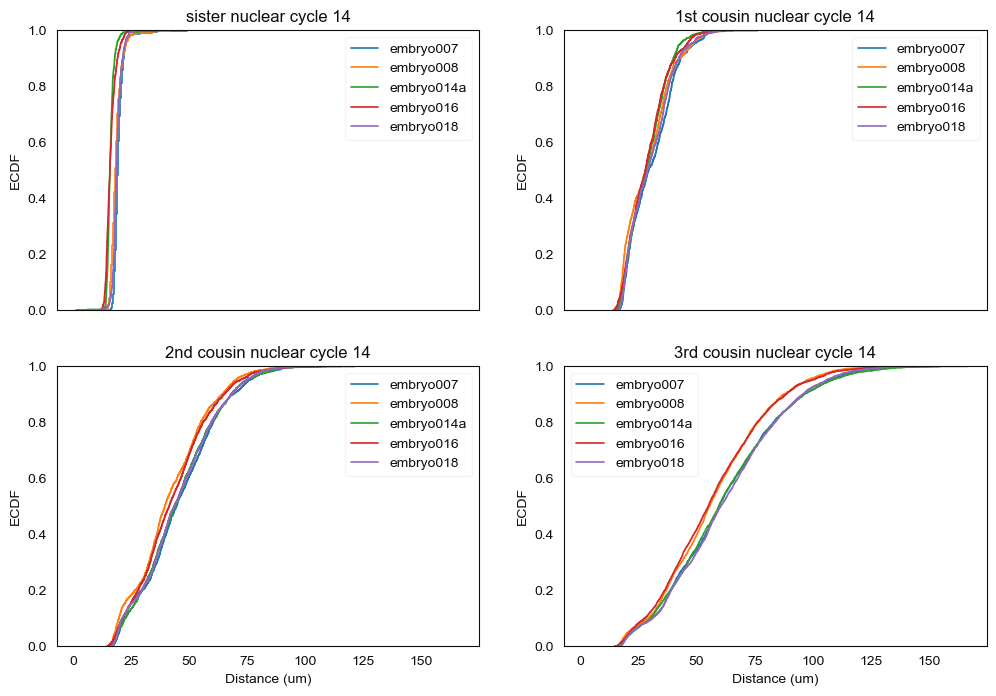

In [79]:

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
for i, ax in enumerate(axes.flatten()):
    for root in roots:
        sns.ecdfplot(all_distances[root][3][i], ax=ax, linewidth=1.2, label=root)
    ax.set_title(f"{labels[i + 1]} nuclear cycle 14")
    ax.legend()
    ax.set_xlabel("Distance (um)")
    ax.set_ylabel("ECDF")
plt.savefig(plotpath / "cousins/cousin_distances_ecdf.png", dpi=300)

In [88]:
print(all_distances[roots[0]])

IndexError: list index out of range

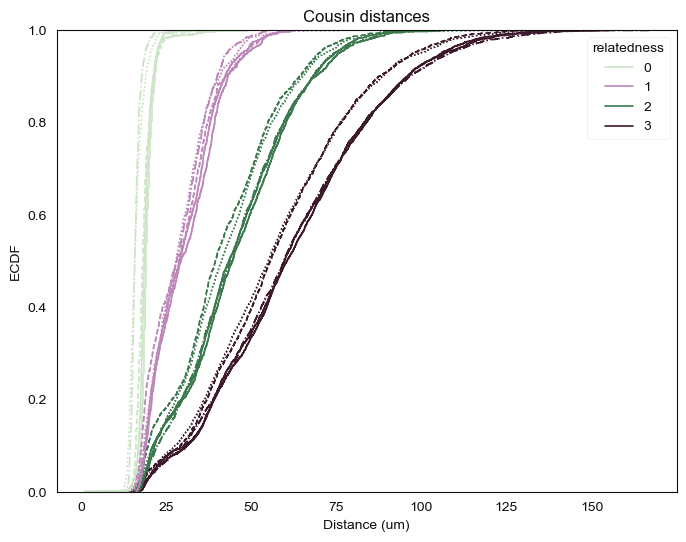

In [109]:
rooti = []
cycles = []
relatedness = []
d = []

for root in roots:
    for cycle in [11, 12, 13, 14]:
        for i, distancelist in enumerate(all_distances[root][cycle - 11]):
            for distance in distancelist:
                rooti.append(root)
                cycles.append(cycle)
                relatedness.append(i)
                d.append(distance)
                
df = pd.DataFrame({
    "root": rooti,
    "cycle": cycles,
    "relatedness": relatedness,
    "distance": d
})

fig, ax = plt.subplots(figsize=(8, 6))
for root, style in zip(roots, ["-", "--", "-.", ":", "-"]):
    sns.ecdfplot(df[(df["root"]==root) & (df["cycle"]==14)], x="distance", hue="relatedness", linestyle=style, palette=cpal, ax=ax, linewidth=1.2, label=root)
plt.title("Cousin distances")
plt.xlabel("Distance (um)")
plt.ylabel("ECDF")
plt.savefig(plotpath / "cousins/cousin_distances_ecdf_all.png", dpi=300)
plt.show()

In [46]:
from scipy.spatial import Voronoi
from math import floor
import networkx as nx
from matplotlib.collections import LineCollection

root_c = []
cycle_c = []
tracklet_a_c = []
tracklet_b_c = []
track_a_c = []
track_b_c = []
rca_c = []
gen_diff_c = []

for root in roots:
    root_frames = range(int(spots[root]["FRAME"].max()))
    xmin, ymin = spots[root][["um_x", "um_y"]].min()
    xmax, ymax = spots[root][["um_x", "um_y"]].max()    
    for frame in tqdm(root_frames):
        df = spots[root]
        df = df[df["FRAME"] == frame]
        cycle = df["cycle"].median()
        pts = df[["um_x", "um_y"]].values
        tracklet_ids = df["tracklet_id"].values
        track_ids = df["track_id"].values
        
        fig, ax = plt.subplots(figsize=(6, 4))
        
        vor = Voronoi(pts)
            
        good_tracklets = tracklets[root][tracklets[root]["track_n_tracklets"] > 15]
        tracklet_parents = {tracklet: parent for tracklet, parent in zip(tracklets[root]["tracklet_id"], tracklets[root]["parent_tracklet"])}
        lines = []
        linecolors = []
        points = []
        pointcolors = []
        
        seen_pairs = set()
        
        for a, b in vor.ridge_points:
            if a == -1 or b == -1:
                continue
                
            # if not tracklet_ids[a] in good_tracklets["tracklet_id"] or not tracklet_ids[b] in good_tracklets["tracklet_id"]:
            #     continue
            if (a, b) in seen_pairs or (b, a) in seen_pairs:
                continue
            seen_pairs.add((a, b))
            
            max_dis = 45
            if np.linalg.norm(pts[a] - pts[b]) > max_dis:
                continue
                
            track_a = tracklet_ids[a]
            track_b = tracklet_ids[b]
            dist, diff = cousin_distance(tracklet_parents, track_a, track_b)
            
            if dist > 4 or diff > 4:
                continue
                    
            lines.append([(pts[a, 0], pts[a, 1]), (pts[b, 0], pts[b, 1])])
            linecolors.append(colors[dist])
            points.append(pts[a])
            points.append(pts[b])
            pointcolors.append(g_palette[track_ids[a] % 1024])
            pointcolors.append(g_palette[track_ids[b] % 1024])
            
            
        lc = LineCollection(lines, colors=linecolors, linewidths=1, zorder=1)
        ax.add_collection(lc)
        # make black background 
        ax.set_facecolor(palette["black"])
        for i in range(5):
            plt.plot([], [], color=colors[i], label=labels[i])
        plt.legend(loc="upper left", fontsize="xx-small")
        points = np.array(points)
        # plt.scatter(points[:, 0], points[:, 1], c=pointcolors, s=50*(0.75**(cycle - 4)), zorder=2)
        ax.set_aspect("equal")
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.grid(False)
        # remove axes
        ax.set_xticks([])
        ax.set_yticks([])
        savefolder = plotpath / f"cousins/{root}_alt"
        savefolder.mkdir(exist_ok=True)
        plt.savefig(savefolder / f"{frame:03d}.png", dpi=300, bbox_inches="tight", pad_inches=0)
        plt.close()
        


100%|██████████| 379/379 [01:27<00:00,  4.33it/s]


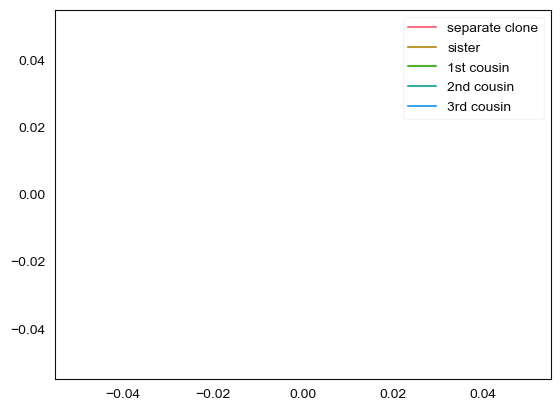

In [13]:
for i in range(5):
    plt.plot([], [], color=pal[i], label=labels[i])
plt.legend()
plt.grid(False)
plt.savefig(plotpath / "cousins/legend.png", dpi=300)

0


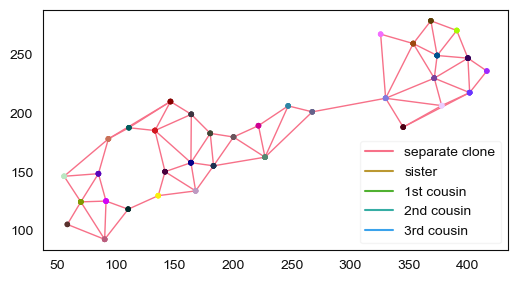

0


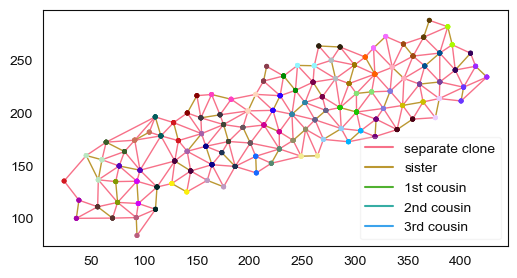

0


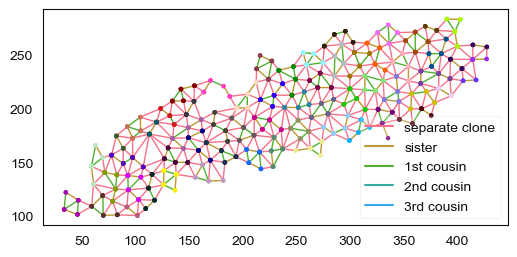

0


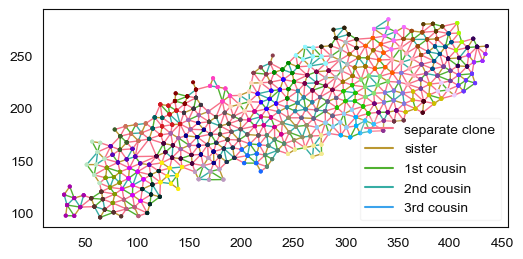

0


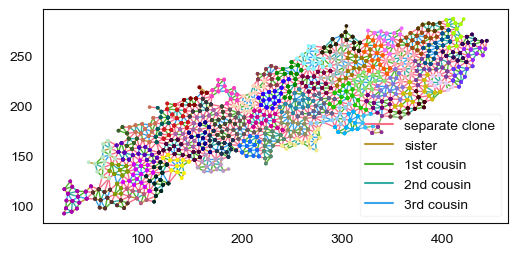

1


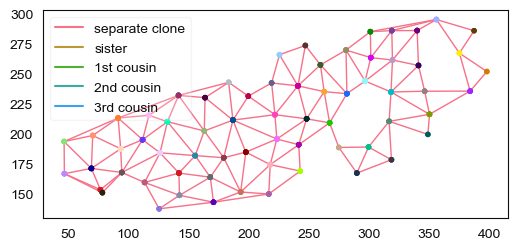

0


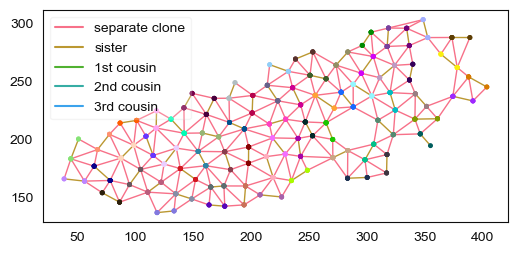

0


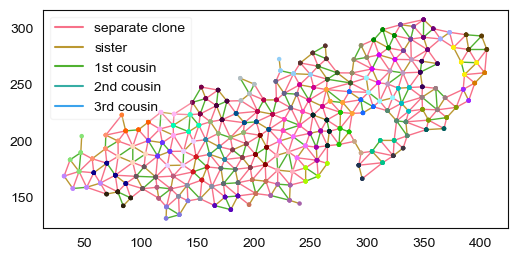

0


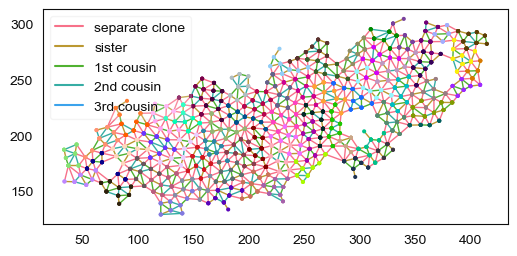

0


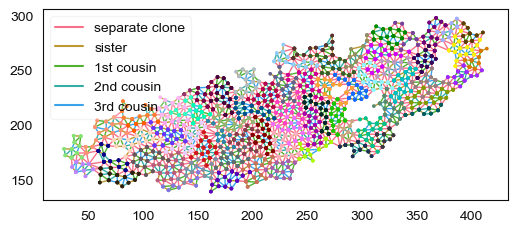

0


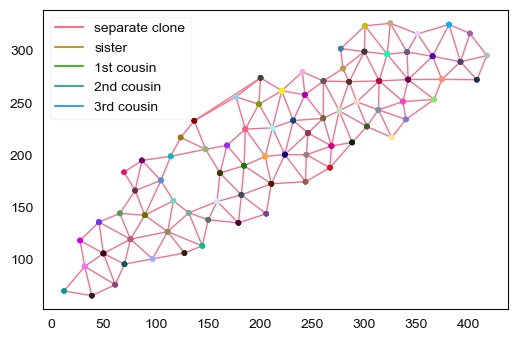

0


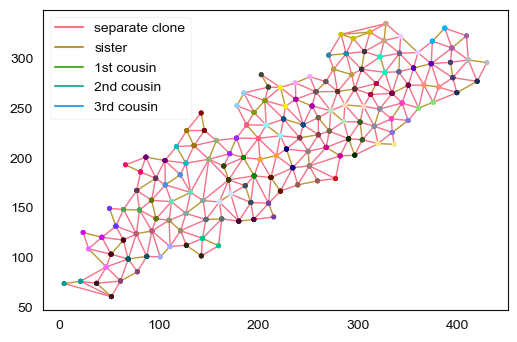

0


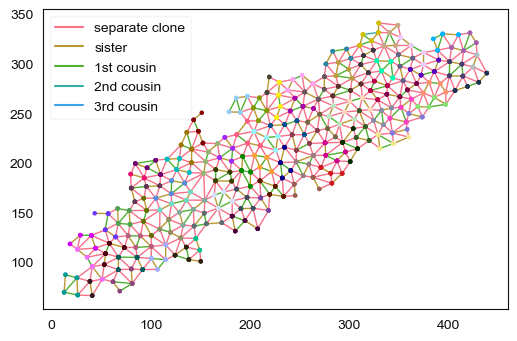

0


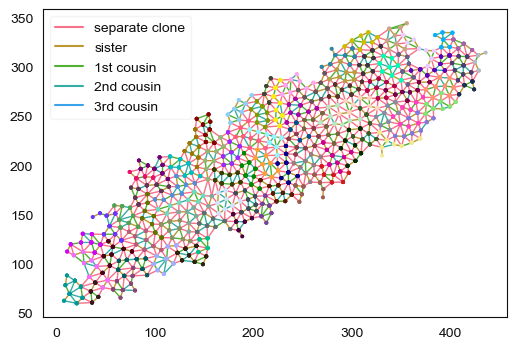

0


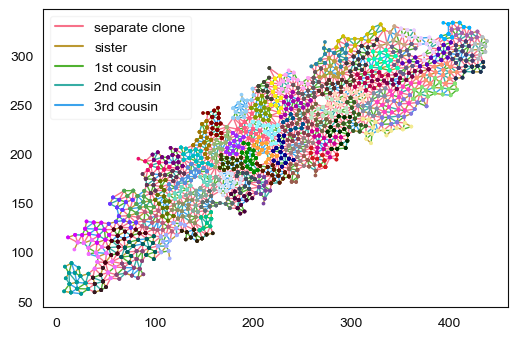

10


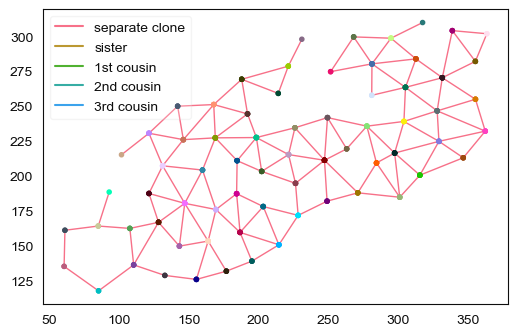

0


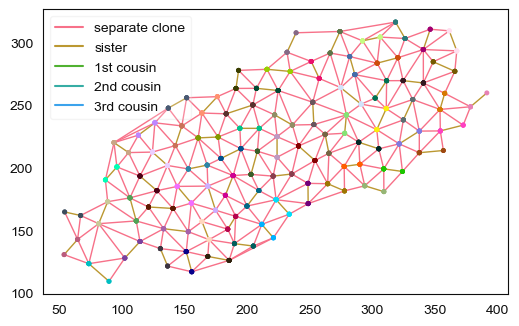

0


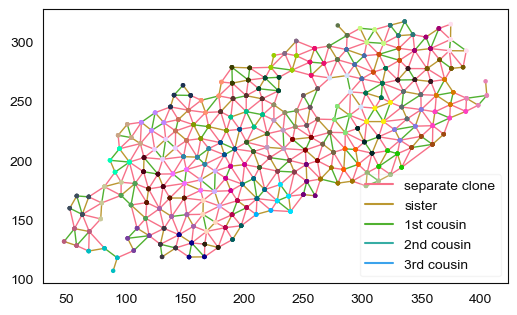

0


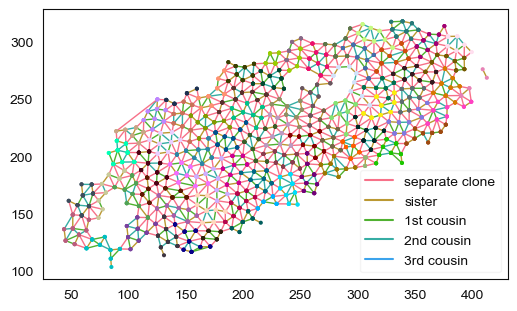

0


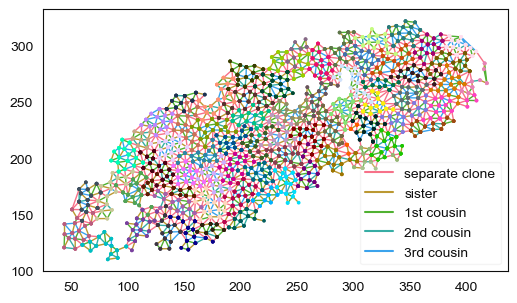

0


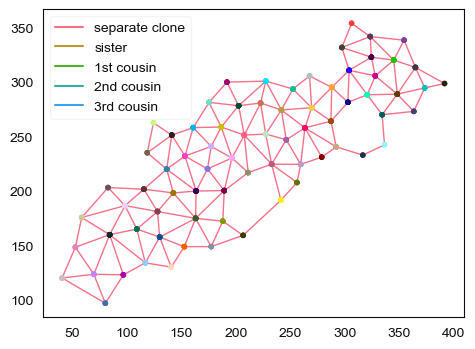

0


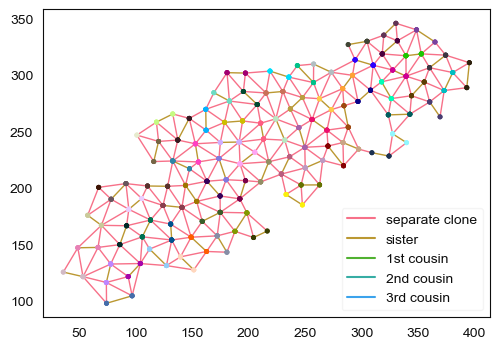

0


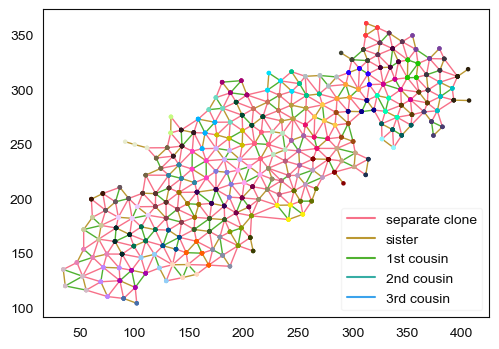

0


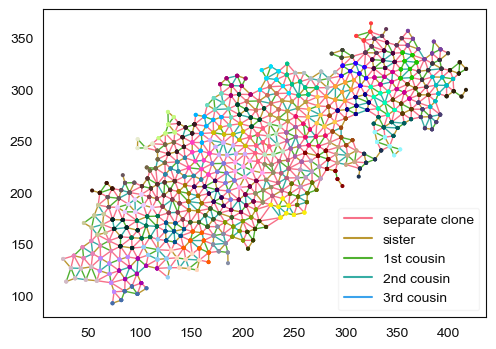

0


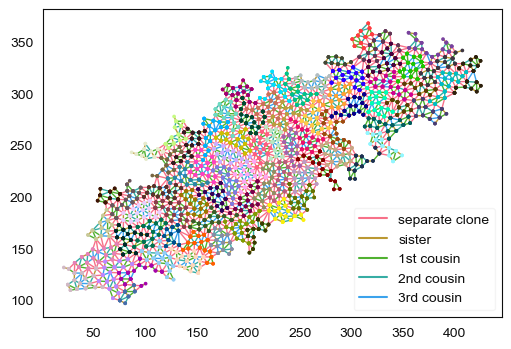

In [13]:
from scipy.spatial import Voronoi
from math import floor
import networkx as nx
from matplotlib.collections import LineCollection

root_c = []
cycle_c = []
tracklet_a_c = []
tracklet_b_c = []
track_a_c = []
track_b_c = []
rca_c = []
gen_diff_c = []

for root in roots:
    root_frames = range(int(spots[root]["FRAME"].max()))
    for cycle in [10, 11, 12, 13, 14]:
        df = spots[root]
        df = df[df["cycle"] == cycle]
        frame = df["FRAME"].median()
        df = df[df["FRAME"] == frame]
        pts = df[["um_x", "um_y"]].values
        tracklet_ids = df["tracklet_id"].values
        print(len(tracklet_ids) - len(set(tracklet_ids))) # check for duplicates)
        track_ids = df["track_id"].values
        
        fig, ax = plt.subplots(figsize=(6, 4))
        
        vor = Voronoi(pts)
            
        good_tracklets = tracklets[root][tracklets[root]["track_n_tracklets"] > 15]
        tracklet_parents = {tracklet: parent for tracklet, parent in zip(good_tracklets["tracklet_id"], good_tracklets["parent_tracklet"])}
        lines = []
        linecolors = []
        points = []
        pointcolors = []
        
        seen_pairs = set()
        
        for a, b in vor.ridge_points:
            if a == -1 or b == -1:
                continue
                
            if not tracklet_ids[a] in good_tracklets["tracklet_id"] or not tracklet_ids[b] in good_tracklets["tracklet_id"]:
                continue
                
                
            track_a = tracklet_ids[a]
            track_b = tracklet_ids[b]
            dist, diff = cousin_distance(tracklet_parents, track_a, track_b)
            
            if dist > 4 or diff > 4:
                continue
                    
            lines.append([(pts[a, 0], pts[a, 1]), (pts[b, 0], pts[b, 1])])
            linecolors.append(colors[dist])
            points.append(pts[a])
            points.append(pts[b])
            pointcolors.append(g_palette[track_ids[a] % 1024])
            pointcolors.append(g_palette[track_ids[b] % 1024])
            
            root_c.append(root)
            cycle_c.append(cycle)
            tracklet_a_c.append(track_a)
            tracklet_b_c.append(track_b)
            track_a_c.append(track_ids[a])
            track_b_c.append(track_ids[b])
            rca_c.append(dist)
            gen_diff_c.append(diff)
            
        lc = LineCollection(lines, colors=linecolors, linewidths=1, zorder=1)
        ax.add_collection(lc)
        # make legend
        for i in range(5):
            ax.plot([], [], color=pal[i], label=labels[i])
        plt.legend()
        points = np.array(points)
        plt.scatter(points[:, 0], points[:, 1], c=pointcolors, s=50*(0.75**(cycle - 4)), zorder=2)
        ax.set_aspect("equal")
        # turn off grid
        ax.grid(False)
        # plt.legend()
        plt.savefig(plotpath / f"cousins/{root}_cycle_{cycle}_cousins.png", dpi=300)
        plt.show()
        
cousin_df = pd.DataFrame({
    "root": root_c,
    "cycle": cycle_c,
    "tracklet_a": tracklet_a_c,
    "tracklet_b": tracklet_b_c,
    "track_a": track_a_c,
    "track_b": track_b_c,
    "rca": rca_c,
    "gen_diff": gen_diff_c})   

reverse = pd.DataFrame({
    "root": root_c,
    "cycle": cycle_c,
    "tracklet_a": tracklet_b_c,
    "tracklet_b": tracklet_a_c,
    "track_a": track_b_c,
    "track_b": track_a_c,
    "rca": rca_c,
    "gen_diff": gen_diff_c})

cousin_df = pd.concat([cousin_df, reverse])
cousin_df["tracklet_root"] = cousin_df["root"] + cousin_df["tracklet_a"].astype(str)
cousin_df["root_cycle"] = cousin_df["root"] + "_cycle_" + cousin_df["cycle"].astype(str)

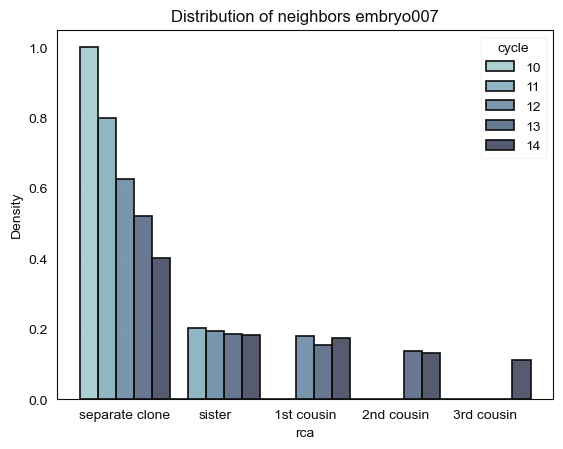

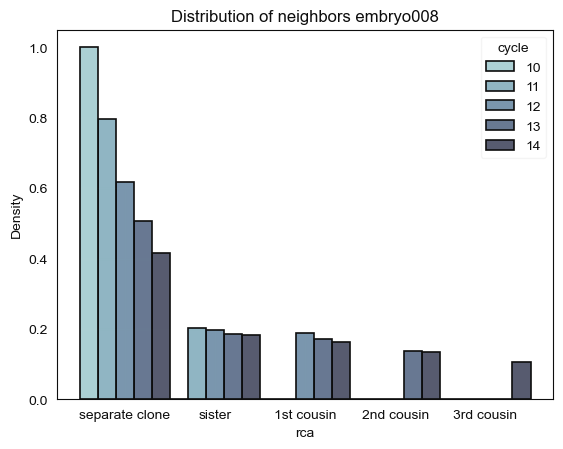

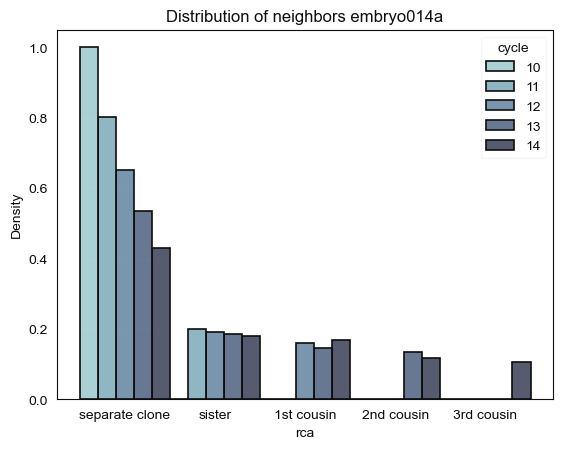

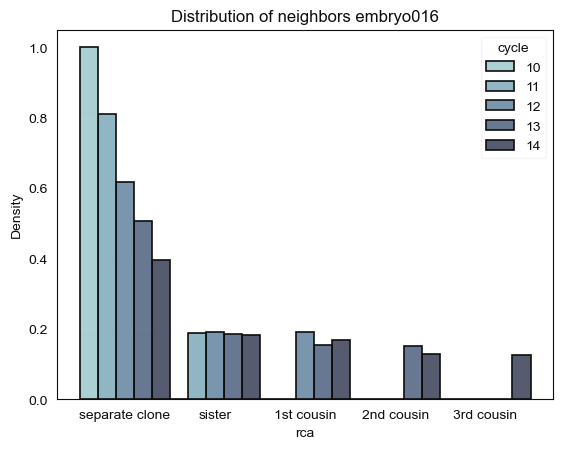

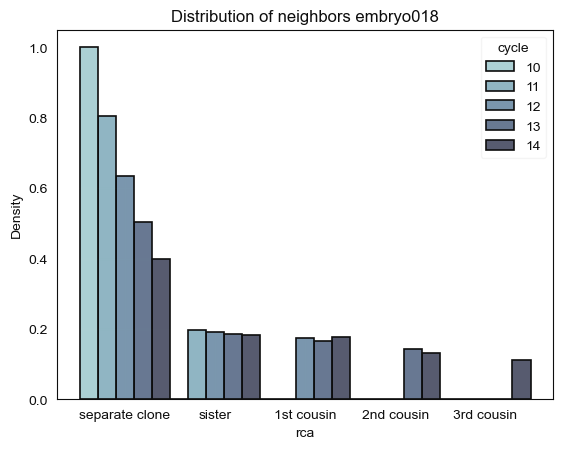

count    321.000000
mean       4.436137
std        1.399711
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        9.000000
Name: root, dtype: float64
cycle 10 avg neighbors: 4.43613707165109


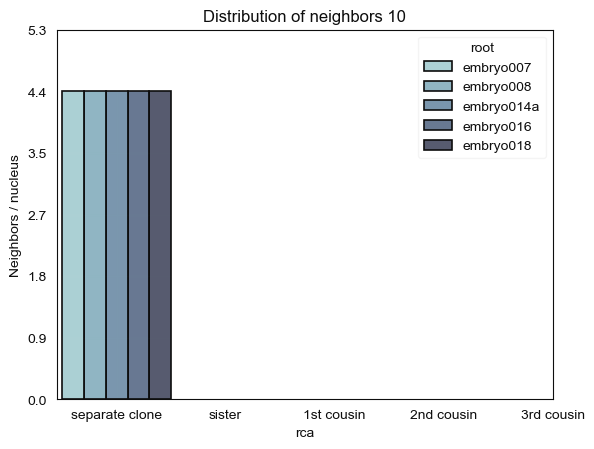

count    694.000000
mean       5.080692
std        1.405761
min        1.000000
25%        4.000000
50%        5.000000
75%        6.000000
max        8.000000
Name: root, dtype: float64
cycle 11 avg neighbors: 5.0806916426512965


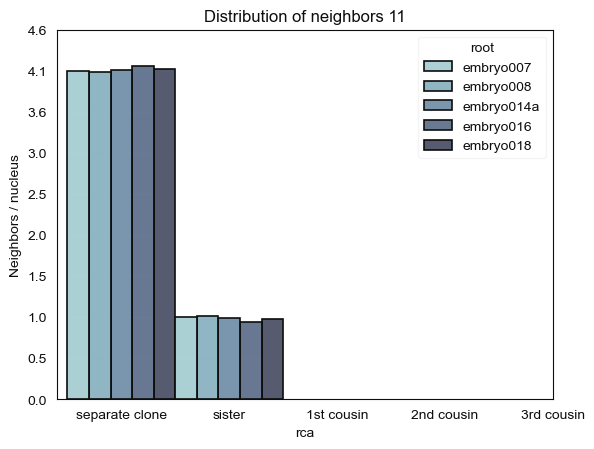

count    1329.000000
mean        5.223476
std         1.367828
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max         8.000000
Name: root, dtype: float64
cycle 12 avg neighbors: 5.223476297968397


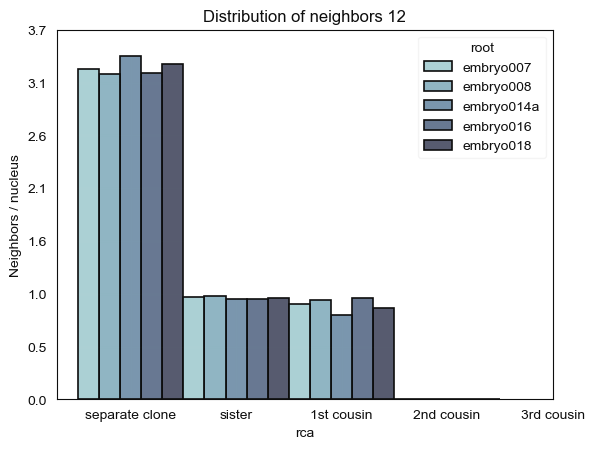

count    2593.000000
mean        5.369842
std         1.315318
min         1.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: root, dtype: float64
cycle 13 avg neighbors: 5.369841881989973


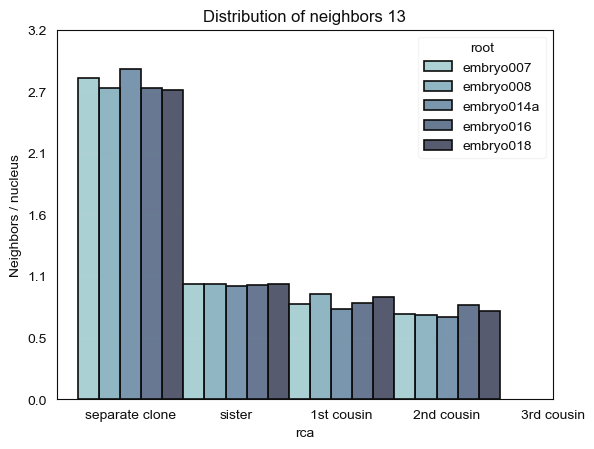

count    4987.000000
mean        5.504712
std         1.218147
min         1.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: root, dtype: float64
cycle 14 avg neighbors: 5.504712251854823


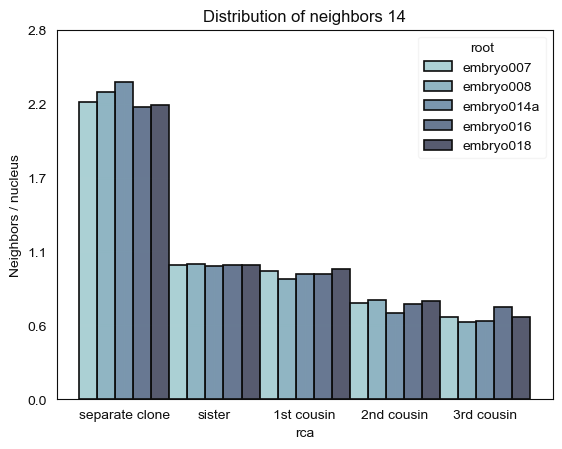

In [17]:
blue_palette = sns.cubehelix_palette(5, rot=-.25, light=.7)

for root in roots:
    sns.histplot(cousin_df[cousin_df["root"]==root], x="rca", hue="cycle", stat="density", multiple="dodge", common_norm=False, edgecolor=palette["black"], linewidth=1.2, discrete=True, palette=blue_palette)
    plt.title(f"Distribution of neighbors {root}")
    # use labels to relabel x axis
    plt.xticks(range(5), [labels[i] for i in range(5)])
    plt.savefig(plotpath / f"cousins/{root}_neighbors.png", dpi=300)
    plt.show()
    
for cycle in [10, 11, 12, 13, 14]:
    sns.histplot(cousin_df[cousin_df["cycle"]==cycle], x="rca", hue="root", stat="density", multiple="dodge", common_norm=False, edgecolor=palette["black"], linewidth=1.2, discrete=True, palette=blue_palette)
    plt.title(f"Distribution of neighbors {cycle}")
    # use labels to relabel x axis
    plt.xticks(range(5), [labels[i] for i in range(5)])
    # multiply y axis by average neighbors
    print(cousin_df[cousin_df["cycle"]==cycle].groupby("tracklet_root")["root"].count().describe())
    avg_neighbors = cousin_df[cousin_df["cycle"]==cycle].groupby("tracklet_root")["root"].count().mean()
    print(f"cycle {cycle} avg neighbors: {avg_neighbors}")
    plt.yticks(plt.yticks()[0], [f"{(tick * avg_neighbors):0.1f}" for tick in plt.yticks()[0]])
    plt.ylabel("Neighbors / nucleus")
    plt.savefig(plotpath / f"cousins/{cycle}_neighbors.png", dpi=300)
    plt.show()

In [23]:
metadatas["embryo007"]

{'name': 'embryo007',
 'frames_per_minute': 4,
 'pixels_per_um': 3,
 'a_x': -20,
 'a_y': 240,
 'p_x': 1390,
 'p_y': 806,
 'h': 1360,
 'w': 1360,
 'n_divisions': 4,
 'division_times': [0, 7, 53, 105, 182]}

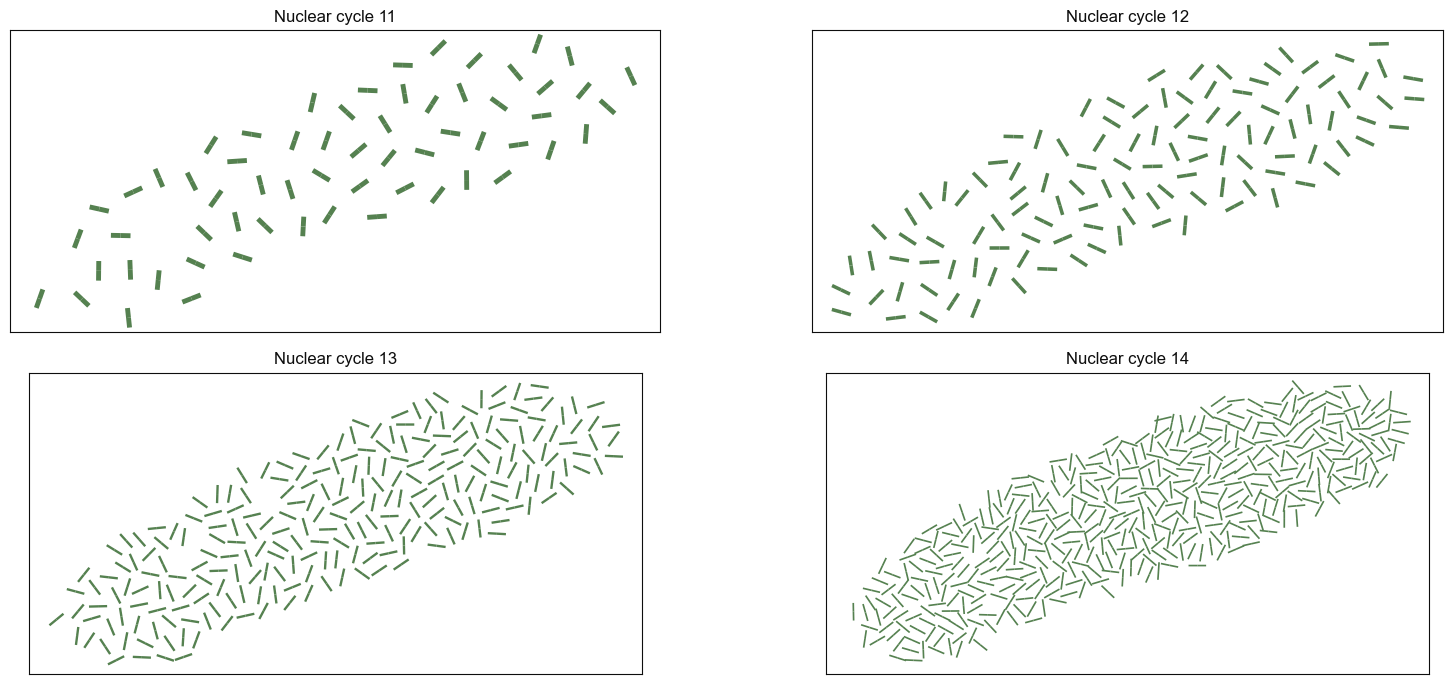

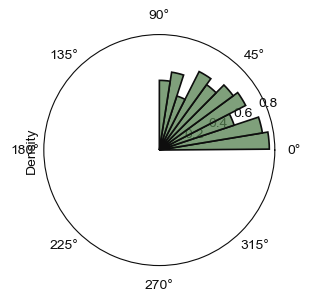

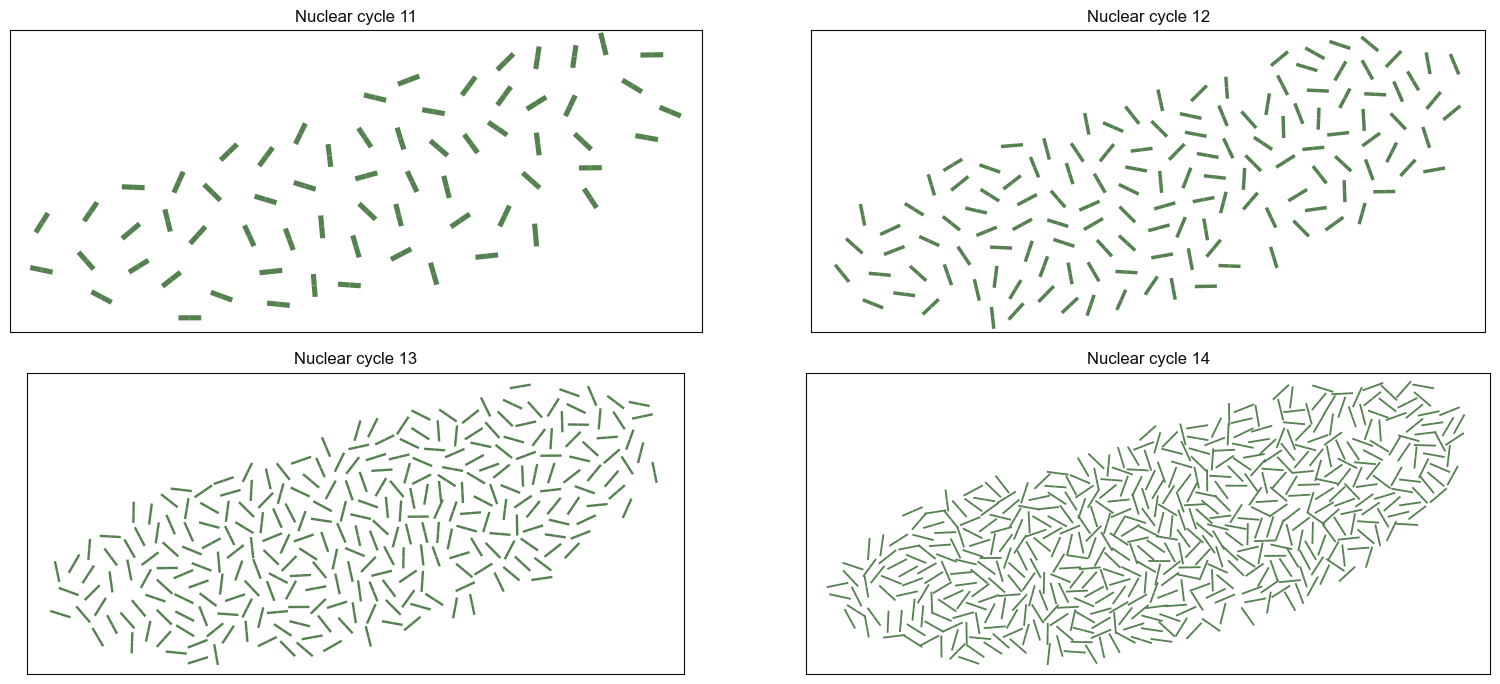

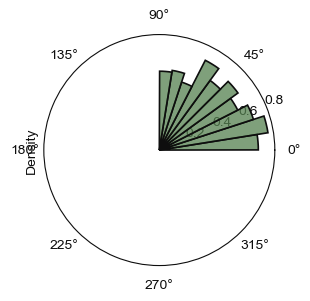

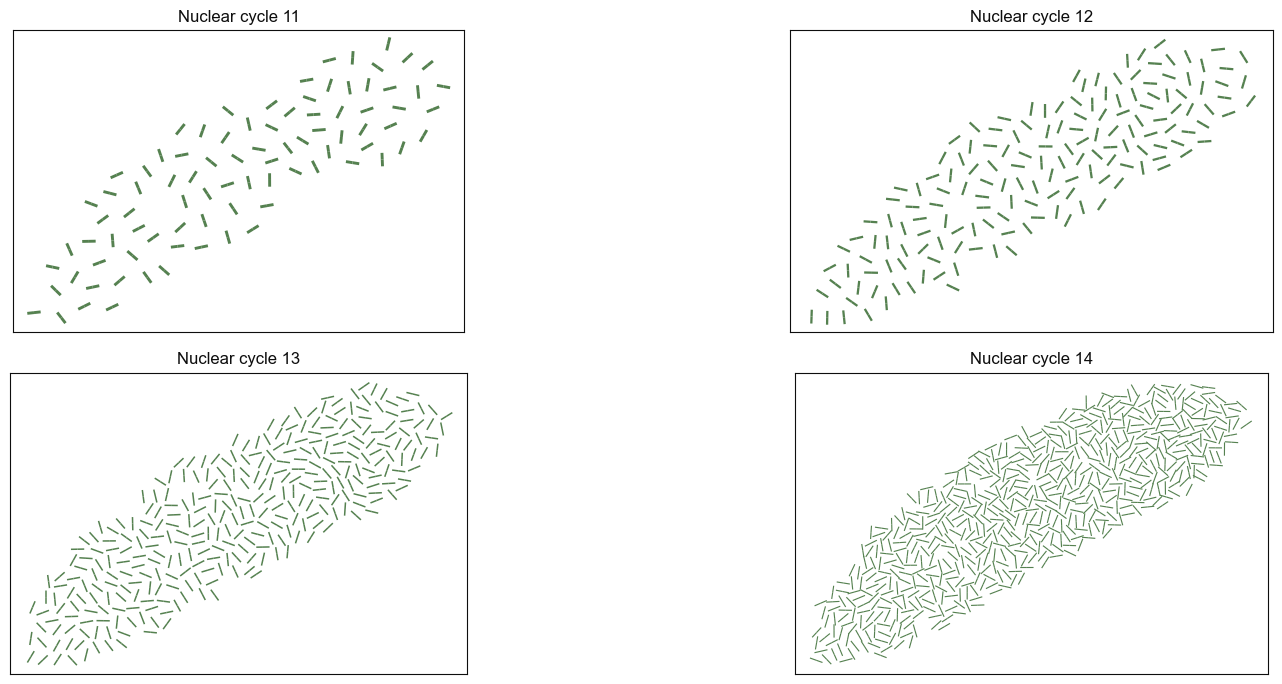

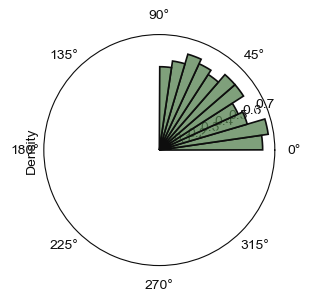

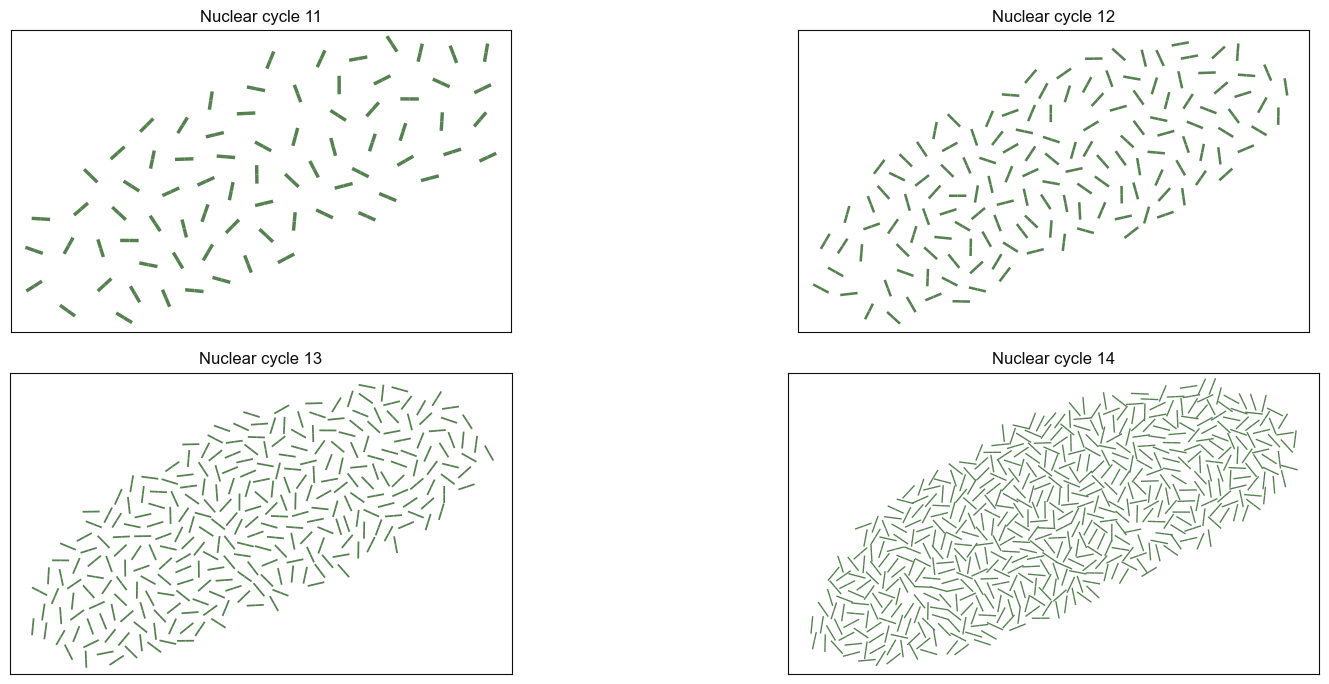

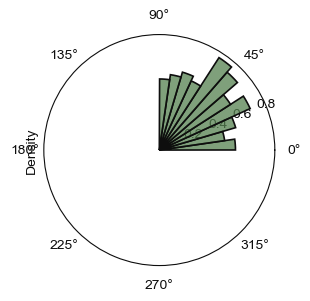

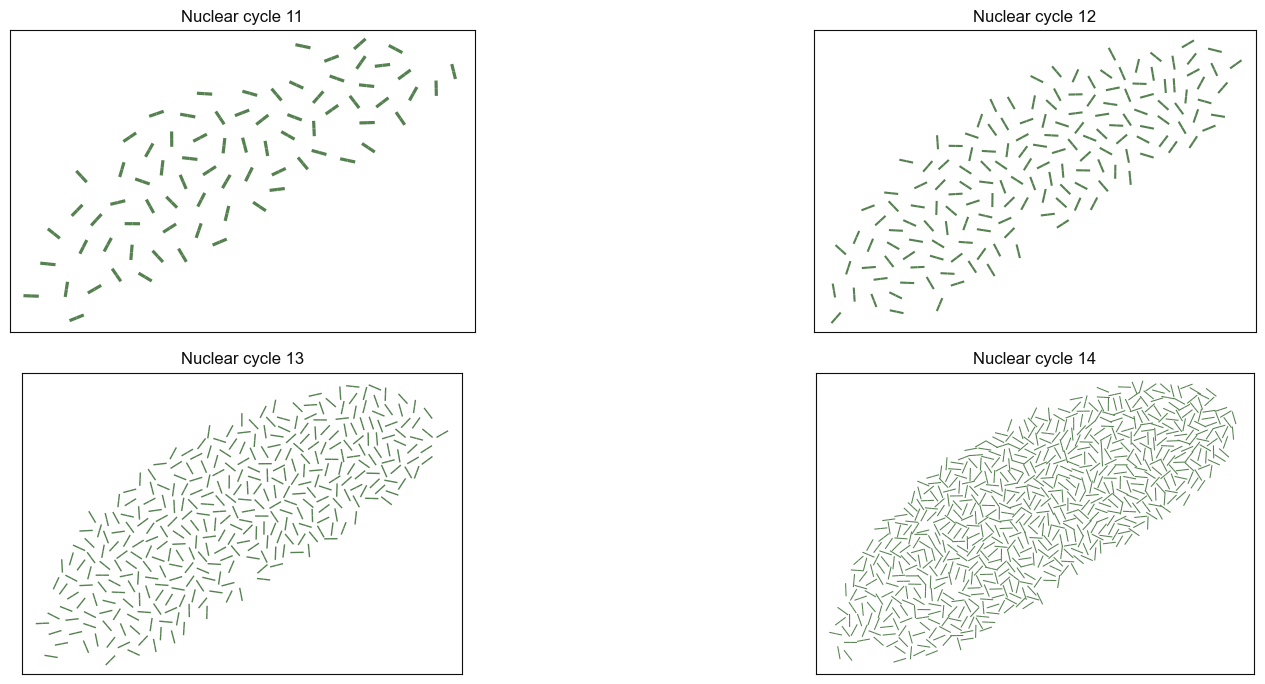

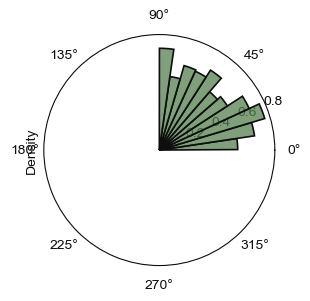

In [47]:
for root in roots:
    fig, axes = plt.subplots(2, 2, figsize=(16, 7))
    plt.tight_layout()
    
    a_x, a_y, p_x, p_y = metadatas[root]["a_x"], metadatas[root]["a_y"], metadatas[root]["p_x"], metadatas[root]["p_y"]
    ap_axis_angle = np.arctan2(p_y - a_y, p_x - a_x)
    
    for cycle, ax in zip(range(11, 15), axes.flatten()):
        r_tracklets = tracklets[root]
        this_tracklets = r_tracklets[r_tracklets["cycle"] == cycle]
        
        source_pos = {tracklet: [] for tracklet in this_tracklets[~this_tracklets["parent_tracklet"].isin([-1, 0])]["parent_tracklet"]}
        
        x, y = this_tracklets.initial_x, this_tracklets.initial_y
        for parent, this_x, this_y in zip(this_tracklets["parent_tracklet"], x, y):
            if (parent == -1) or (parent == 0):
                continue
            source_pos[parent].append((this_x, this_y))
            
        source_pos = {tracklet: pos for tracklet, pos in source_pos.items() if len(pos) == 2}
                
        prev_tracklets = r_tracklets[r_tracklets["cycle"] == cycle - 1]
        prev_tracklets = prev_tracklets[prev_tracklets["tracklet_id"].isin(source_pos.keys())]
            
        missing = [tracklet for tracklet in source_pos.keys() if tracklet not in prev_tracklets["tracklet_id"]]
        source_pos = {tracklet: pos for tracklet, pos in source_pos.items() if tracklet not in missing}
        
        x = [prev_tracklets.loc[tracklet, "final_x"] for tracklet in source_pos.keys()]
        y = [prev_tracklets.loc[tracklet, "final_y"] for tracklet in source_pos.keys()]
        c = [prev_tracklets.loc[tracklet, "end_time"] for tracklet in source_pos.keys()]
        
        div_angle = lambda pt1, pt2: np.arctan2(pt2[1] - pt1[1], pt2[0] - pt1[0])
        angles = [div_angle(pts[0], pts[1]) for pts in source_pos.values()]
        u = np.cos(angles)
        v = np.sin(angles)
        
        x_y_rat = (np.max(x) - np.min(x)) / (np.max(y) - np.min(y))
        
        ax.quiver(x, y, u*20, v*20, angles='xy', scale_units='xy', scale=1, color=palette["green"], headwidth=0, headlength=0, headaxislength=0)
        bar = ax.quiver(x, y, -u*20, -v*20, angles='xy', scale_units='xy', scale=1, color=palette["green"], headwidth=0, headlength=0, headaxislength=0)
        ax.set_aspect("equal")
        ax.set_title(f"Nuclear cycle {cycle}")
        ax.set_xticks([])
        ax.set_yticks([])
        # plt.colorbar(bar)
    plt.savefig(plotpath / f"{root} division_angles.png", dpi=150)
    plt.show()
    
    # plot angles relative to axis (0-pi/2)
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), subplot_kw={'projection': 'polar'})
    rel_angles = np.abs(np.array([ap_axis_angle - angle for angle in angles])) % np.pi
    # print(rel_angles)
    rel_angles = np.where(rel_angles > np.pi / 2, np.pi - rel_angles, rel_angles)
    sns.histplot(rel_angles, ax=ax, stat="density", common_norm=False, edgecolor=palette["black"], color=palette["green"], linewidth=1.2)
    plt.savefig(plotpath / f"{root} division_angles_hist.png", dpi=300)
    plt.show()



In [47]:
from scipy.spatial import Voronoi
from math import floor
import networkx as nx

graphs = {}
neighbors_all, graph_distances_all, graph_max_all = [], [], []
um_distances_all = []
counts_all = []
# con_counts_all = []

for root in roots:
    graphs[root] = []
    for frame in tqdm(range(int(spots[root]["FRAME"].max()))):
        graph = nx.Graph()
        
        embryo_points = spots[root]
        embryo_points = embryo_points[embryo_points["FRAME"] == frame]

        pts = embryo_points[["um_x", "um_y"]].values
        tracklet_ids = embryo_points["tracklet_id"].values

        vor = Voronoi(pts)

        for a, b in vor.ridge_points:
            graph.add_edge(tracklet_ids[a], tracklet_ids[b])
            
        graphs[root].append(graph)
        
    this_tracklets = tracklets[root]
    
    track_counts = this_tracklets["track_id"].value_counts()
    best_tracks = track_counts[track_counts == 31].index
    
    track_tracklets = {key: [] for key in best_tracks}
    best_tracklets = this_tracklets[this_tracklets["track_id"].isin(best_tracks)]
    for tracklet in best_tracklets.index:
        track_tracklets[best_tracklets.loc[tracklet, "track_id"]].append(tracklet)
        
    this_tracklets["parent_tracklet"].fillna(0, inplace=True)
        
    tracklet_parents = {tracklet: parent for tracklet, parent in zip(this_tracklets["tracklet_id"], this_tracklets["parent_tracklet"])}
    
    neighbors = np.zeros((5, 5))
    graph_distances = np.zeros((5, 5))
    graph_max = np.zeros((5, 5))
    counts = [[[] for _ in range(5)] for _ in range(5)]
    um_dist = [[[] for _ in range(5)] for _ in range(5)]
    
    for track in tqdm(best_tracks):
        for frame in range(len(graphs[root])):
            subgraph = graphs[root][frame].subgraph(track_tracklets[track])
            nodes = list(subgraph.nodes)

            for i, a in enumerate(nodes):
                for j, b in enumerate(nodes):
                    if i >= j:
                        continue
                    dist, diff = cousin_distance(tracklet_parents, a, b)
                    if dist > 4 or diff > 4:
                        print("warn")
                    else:
                        neighbors[dist, diff] += 1
                        g_dis = nx.shortest_path_length(graphs[root][frame], a, b)
                        xa, ya = this_tracklets.loc[a, "final_x"], this_tracklets.loc[a, "final_y"]
                        xb, yb = this_tracklets.loc[b, "final_x"], this_tracklets.loc[b, "final_y"]
                        d_dis = np.linalg.norm([xa - xb, ya - yb])
                        graph_distances[dist, diff] += g_dis
                        graph_max[dist, diff] = max(graph_max[dist, diff], g_dis)
                        counts[dist][diff].append(g_dis)
                        um_dist[dist][diff].append(d_dis)
    neighbors_all.append(neighbors)
    graph_distances_all.append(graph_distances)
    graph_max_all.append(graph_max)
    counts_all.append(counts)
    um_distances_all.append(um_dist)


100%|██████████| 58/58 [00:43<00:00,  1.35it/s]


[48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 48.741868510441165, 37.92539487323537, 37.92539487323537, 37.92539487323537, 37.92539487323537, 37.92539487323537, 37.9

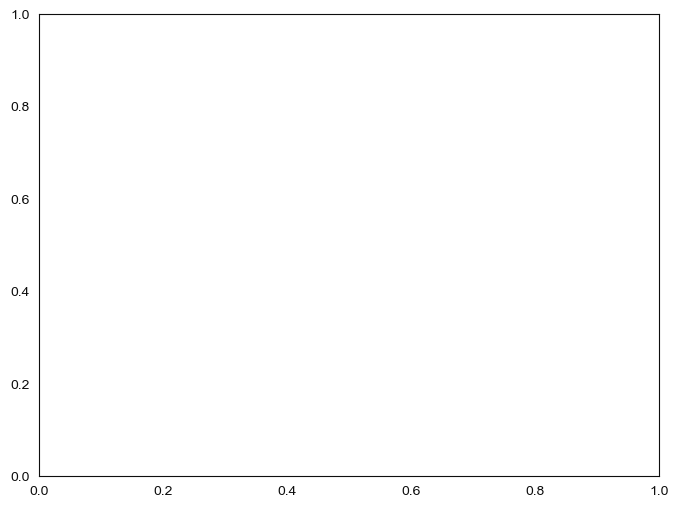

In [50]:
# plot distance distributions
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
print(um_distances_all[0][1][0])

In [26]:
np.sum(neighbors_all)

1459970.0

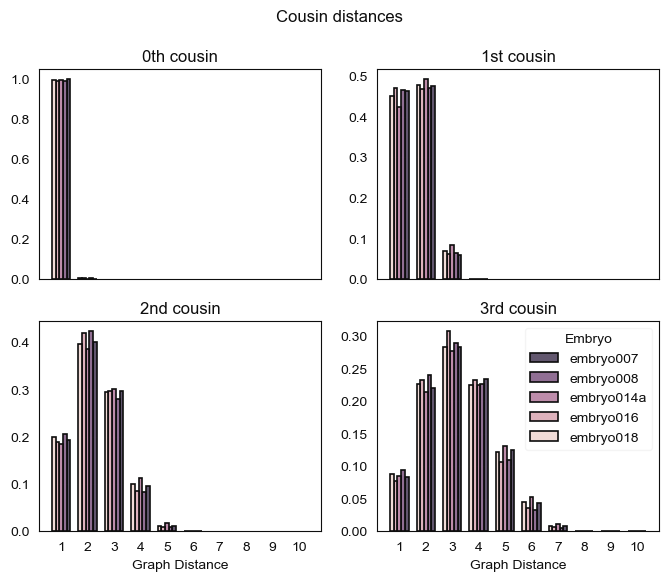

In [20]:
c = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
for j, ax in enumerate(axes.flatten()):
    labels = [i for i, _ in enumerate(roots) for _ in counts_all[i][j + 1][0]]
    vals = [val for i, _ in enumerate(roots) for val in counts_all[i][j + 1][0]]
    df = pd.DataFrame({"vals": vals, "labels": labels})
    sns.histplot(df, x="vals", hue="labels", discrete=True, ax=ax,  stat="density", multiple="dodge", shrink=0.7, common_norm=False, legend=False, edgecolor=palette["black"], linewidth=1.2)
    ax.set_xlabel("Graph Distance")
    ax.set_xticks(range(1, 11))
    ax.set_ylabel("")
    ax.set_title(f'{["0th", "1st", "2nd", "3rd"][j]} cousin')
fig.suptitle(f"Cousin distances")
plt.legend(title="Embryo", labels=roots)
plt.savefig(plotpath / "cousin_distances.png", dpi=150) 
plt.show()

-3.177312053403077
-3.1708036856095414
-3.176723834354081
-3.1694575710956245
1.014278142251314
1.118968675299022
1.0253618540330358
1.0234485039829782
1.9929491215028456
2.102681370063057
1.9406610548789685
2.0280914311369056
3.044241070188224
3.1772925565544443
2.978314819330277
3.1173007840809195


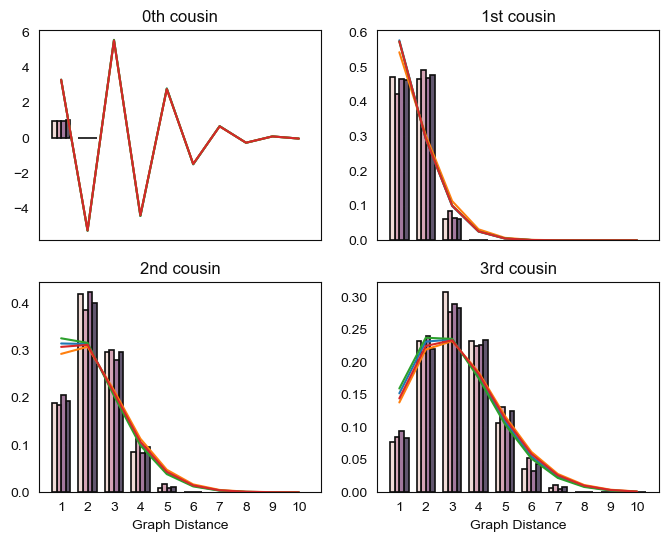

In [30]:
import math

def estimate_lambda(x):
    mean = np.mean(x)
    
    # solve lam / (1 - exp(-lam)) = mean
    lam = 1
    for _ in range(100):
        lam = lam - (lam / (1 - np.exp(-lam)) - mean) / (1 - np.exp(-lam) + lam * np.exp(-lam))

    return lam

# model zero truncated poisson
def zero_truncated_poisson(lam, k):
    return lam**k / ((np.exp(lam) - 1) * math.factorial(k))

fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
for j, ax in enumerate(axes.flatten()):
    labels = [i for i, _ in enumerate(roots) for _ in counts_all[i][j + 1][0]]
    vals = [val for i, _ in enumerate(roots) for val in counts_all[i][j + 1][0]]
    df = pd.DataFrame({"vals": vals, "labels": labels})
    sns.histplot(df, x="vals", hue="labels", discrete=True, ax=ax,  stat="density", multiple="dodge", shrink=0.7, common_norm=False, legend=False, edgecolor=palette["black"], linewidth=1.2)
    ax.set_xlabel("Graph Distance")
    ax.set_xticks(range(1, 11))
    ax.set_ylabel("")
    ax.set_title(f'{["0th", "1st", "2nd", "3rd"][j]} cousin')
    
    for i, root in enumerate(roots):
        lam = estimate_lambda(np.mean(counts_all[i][j + 1][0]))
        print(lam)
        x = np.arange(1, 11)
        y = [zero_truncated_poisson(lam, k) for k in x]
        ax.plot(x, y, color=c[i], label=root)


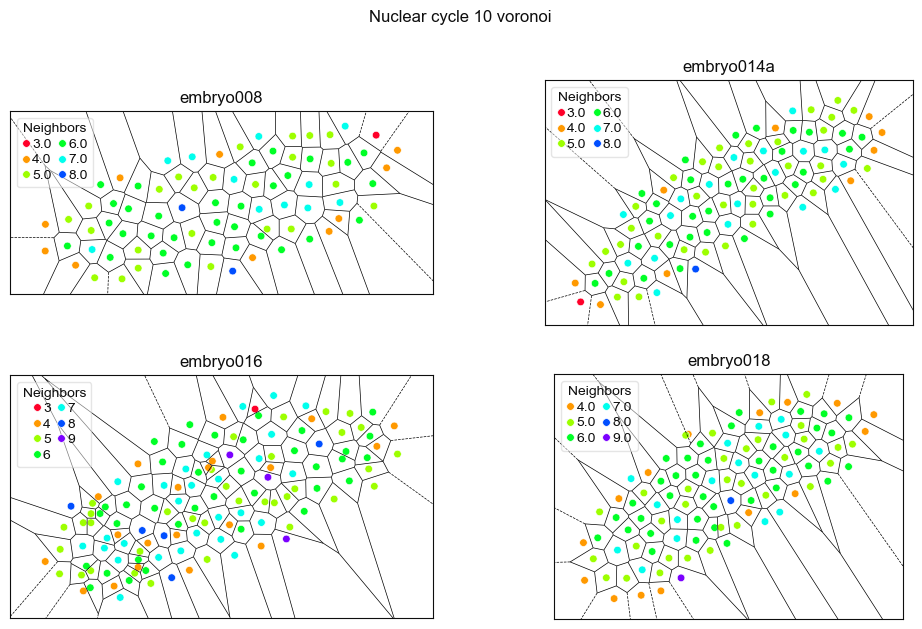

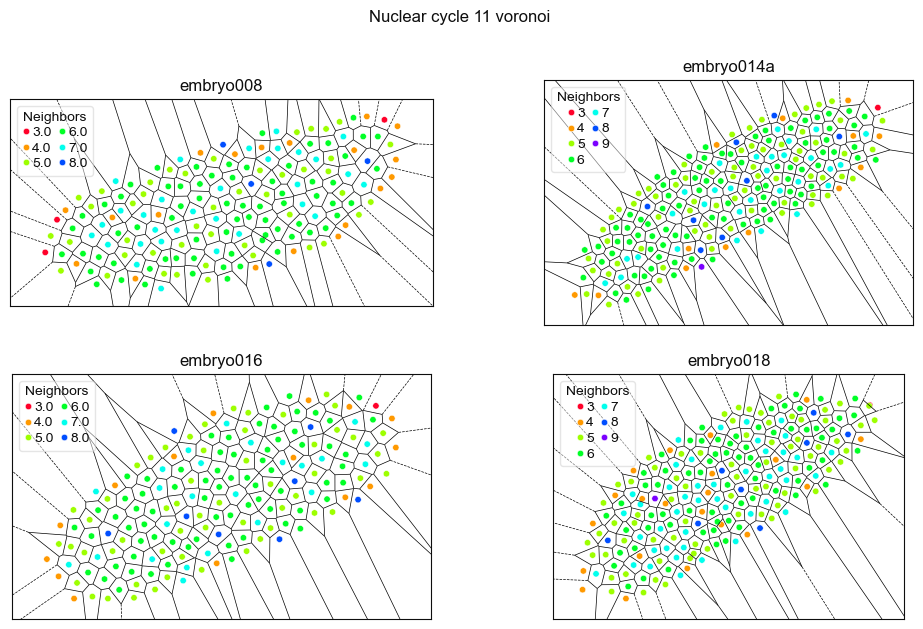

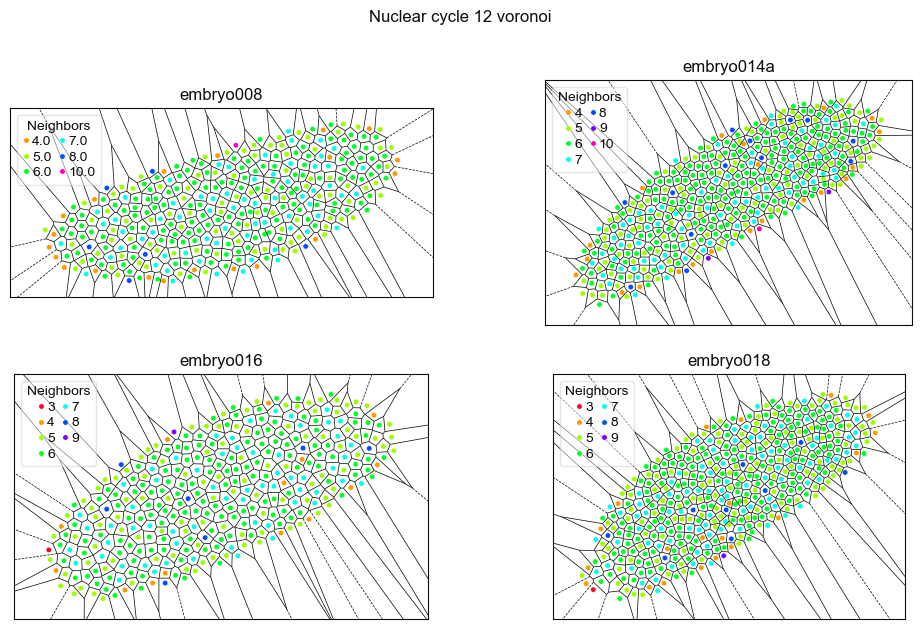

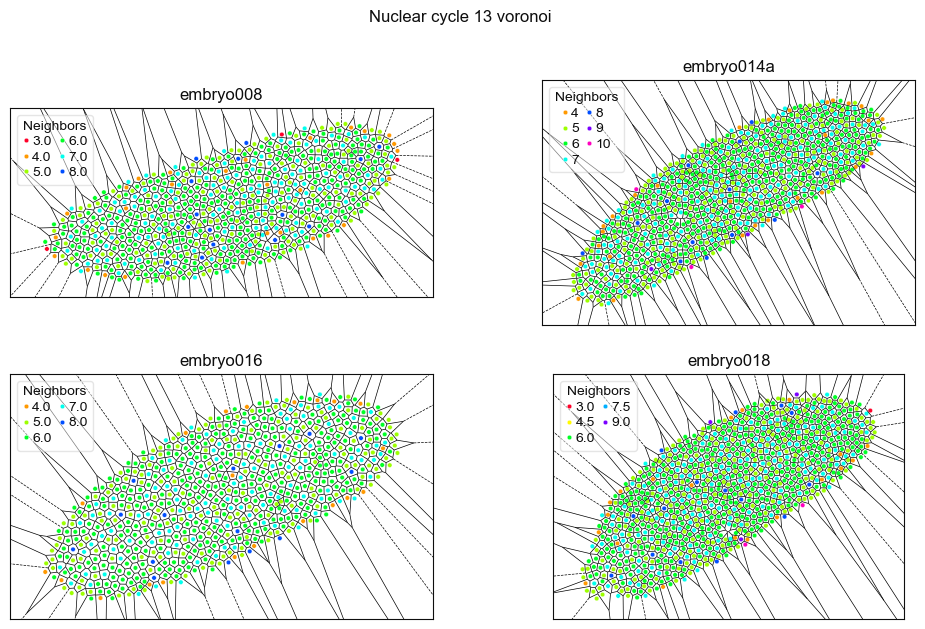

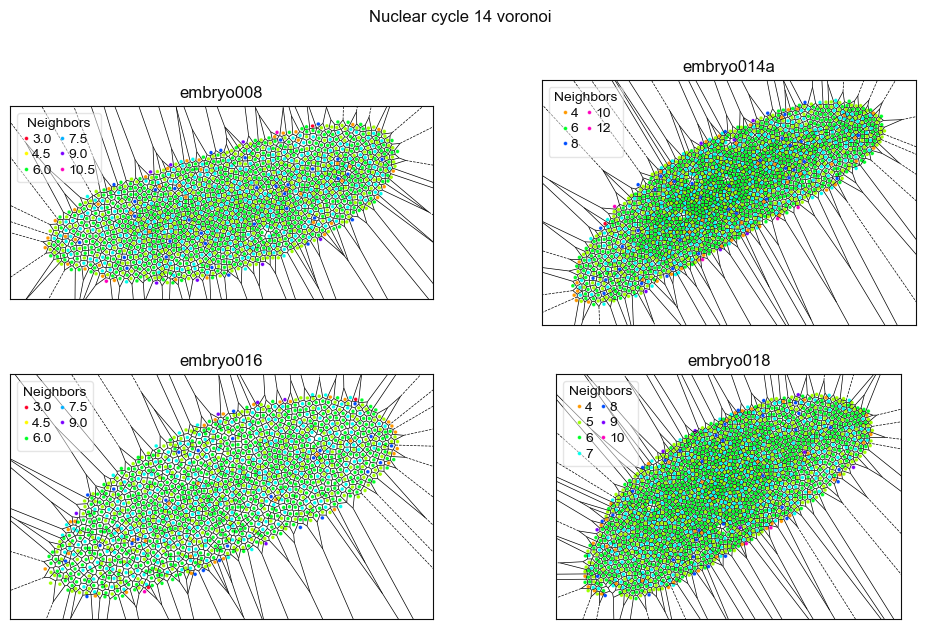

In [17]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from math import floor

for nc in range(5):
    fig, axes = plt.subplots(2, 2, figsize=(12, 7))
    
    for root, ax in zip(roots, axes.flatten()):
        peaks = metadatas[root]["division_times"]
        interphase_dividers = [(p1 + p2) / 2 for p1, p2 in zip(peaks, peaks[1:])]
        interphase_dividers.append((tracklets[root]["end_frame"].max() + peaks[-1]) / 2)
        
        embryo_points = spots[root]
        embryo_points = embryo_points[embryo_points["FRAME"] == floor(interphase_dividers[nc])]

        vor = Voronoi(embryo_points[["um_x", "um_y"]])
        
        n_neighbors = np.zeros(len(embryo_points))
        for a, b in vor.ridge_points:
            if a == -1 or b == -1:
                continue
            n_neighbors[a] += 1
            n_neighbors[b] += 1
        voronoi_plot_2d(vor, ax=ax, show_vertices=False, show_points=False, line_width=0.5)
        norm = plt.Normalize(vmin=3, vmax=10)
        s = 30 / 2**(nc / 2)
        ax.set_aspect("equal")
        sns.scatterplot(x=embryo_points["um_x"],y=embryo_points["um_y"], hue=n_neighbors, ax=ax, palette="gist_rainbow", hue_norm=norm, s=s)
        ax.legend(title="Neighbors", loc="upper left", ncols=2, labelspacing=0.2, columnspacing=0.5, handletextpad=0.2, handlelength=0.5, framealpha=0.5)
        ax.set_title(root)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel("")
        ax.set_xlabel("")
    fig.suptitle(f"Nuclear cycle {nc + 10} voronoi")
    plt.savefig(plotpath / f"voronoi_nc{nc + 10}.png", dpi=150)
    plt.show()